In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import os
import sys

sys.path.append("/gpfswork/rech/owt/uwz81lo/2023-sfh-galaxy-classification")

from sfh_classif.dataset import HorizonAGN



In [4]:

print(tf.__version__)

2.11.0


this prepares the input data to the transformer. instead of tokens, you should use the SFR values at each timestep. MAX_TOKENS is the maximum lenght of SFH.

In [102]:
def discretize(tensor, n_bins):
    """Discretize an array into n bins."""
    tensor = tensor * tf.constant(n_bins-1, dtype=tf.float32)
    return tf.cast(tf.math.round(tensor), dtype=tf.int32)
    

In [151]:
MAX_TOKENS=128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def prepare_batch(batch):
    """
    Preprocess a batch of Portuguese and English sentences for training a machine translation model.

    Args:
        pt: A tensor of Portuguese sentences of shape (batch_size,) and dtype tf.string.
        en: A tensor of English sentences of shape (batch_size,) and dtype tf.string.

    Returns:
        A tuple of two tensors representing the input and output sequences for the model, and a tensor of shape
        (batch_size, max_length) representing the ground truth output sequences. The input sequence tensor has shape
        (batch_size, max_length) and dtype tf.int64, and the output sequence tensor has shape (batch_size, max_length)
        and dtype tf.int64.
    """
    #pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    #pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    #pt = pt.to_tensor()  # Convert to 0-padded dense Tensor
    
    cumulative_mass = batch["cumulative_mass"]
    print(cumulative_mass.shape)
    #cumulative_mass = tf.slice(cumulative_mass, [0,0], [BATCH_SIZE,100])
    cumulative_mass = cumulative_mass[:,::10]
    discretize_cumulative_mass = discretize(cumulative_mass, 100)
    #discretize_cumulative_mass = cumulative_mass
    print(discretize_cumulative_mass)
    
    

    #en = tokenizers.en.tokenize(en). ## replace by custome tokenizer
    #sfh_tok = sfh_tok[:, :(MAX_TOKENS+1)]
    sfh_inputs = discretize_cumulative_mass[:, :-1]  # Drop the [END] tokens
    sfh_labels = discretize_cumulative_mass[:, 1:]   # Drop the [START] tokens

    return sfh_inputs,sfh_labels

function to feed the transformer

In [152]:


def make_batches(ds):
  """
  This function takes a TensorFlow dataset 'ds' and processes it into batches that are ready to be fed to the model.

  Parameters:
  ds (tf.data.Dataset): TensorFlow dataset to be processed into batches

  Returns:
  tf.data.Dataset: Processed and batched TensorFlow dataset

  """
  return (
      ds.shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [153]:

# Ensure tfds does not try to fetch the dataset from the internet
os.environ['NO_GCE_CHECK'] = 'true'
tfds.core.utils.gcs_utils._is_gcs_disabled = True

_JZ_TF_DATASET_DIR = "/gpfsscratch/rech/owt/commun/galaxy_classification/SFH_tdfs"

# The following line will either load the TensorFlow dataset if existing
# or it will create the dataset from the _generate_examples method
dset = tfds.load("HorizonAGN", split=tfds.Split.TRAIN, data_dir=_JZ_TF_DATASET_DIR)

print(dset)

<PrefetchDataset element_spec={'cumulative_mass': TensorSpec(shape=(1220,), dtype=tf.float32, name=None), 'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'mass': TensorSpec(shape=(1220,), dtype=tf.float32, name=None), 'max_time': TensorSpec(shape=(), dtype=tf.int32, name=None), 'time': TensorSpec(shape=(1220,), dtype=tf.float32, name=None)}>


In [154]:

dset = dset.shuffle(BUFFER_SIZE)
# Take only the first quarter of the dataset
dset = dset.take(5000)
print(dset)


<TakeDataset element_spec={'cumulative_mass': TensorSpec(shape=(1220,), dtype=tf.float32, name=None), 'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'mass': TensorSpec(shape=(1220,), dtype=tf.float32, name=None), 'max_time': TensorSpec(shape=(), dtype=tf.int32, name=None), 'time': TensorSpec(shape=(1220,), dtype=tf.float32, name=None)}>


In [155]:
# Create training and validation set batches.
train_batches = make_batches(dset)

for sfh_inputs, sfh_labels in train_batches.take(1):
  break

print(sfh_inputs)
print(sfh_labels)

(None, 1220)
Tensor("Cast:0", shape=(None, 122), dtype=int32)
tf.Tensor(
[[ 0  0  2 ... 99 99 99]
 [ 0  1  1 ... 99 99 99]
 [ 0  1  3 ... 99 99 99]
 ...
 [ 0  0  0 ... 99 99 99]
 [ 0  0  1 ... 99 99 99]
 [ 0  0  0 ... 99 99 99]], shape=(64, 121), dtype=int32)
tf.Tensor(
[[ 0  2  4 ... 99 99 99]
 [ 1  1  1 ... 99 99 99]
 [ 1  3  4 ... 99 99 99]
 ...
 [ 0  0  0 ... 99 99 99]
 [ 0  1  1 ... 99 99 99]
 [ 0  0  1 ... 99 99 99]], shape=(64, 121), dtype=int32)


<function matplotlib.pyplot.show(close=None, block=None)>

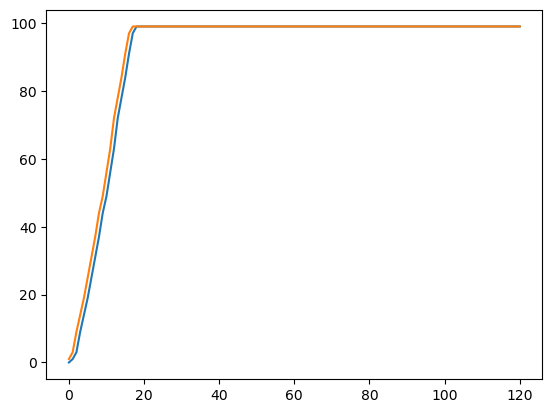

In [156]:
for sfh_inputs1, sfh_labels1 in train_batches.take(100):
  break

plt.plot(sfh_inputs1[37].numpy())
plt.plot(sfh_labels1[37].numpy())
plt.show

positional encoding

In [157]:
def positional_encoding(length, depth):
  """
  Generates a matrix of position encodings for an input sequence.

  Args:
      length: An integer representing the length of the input sequence.
      depth: An integer representing the dimensionality of the encoding.

  Returns:
      A `tf.Tensor` of shape `(length, depth)` representing the position encoding matrix.
  """
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 128)


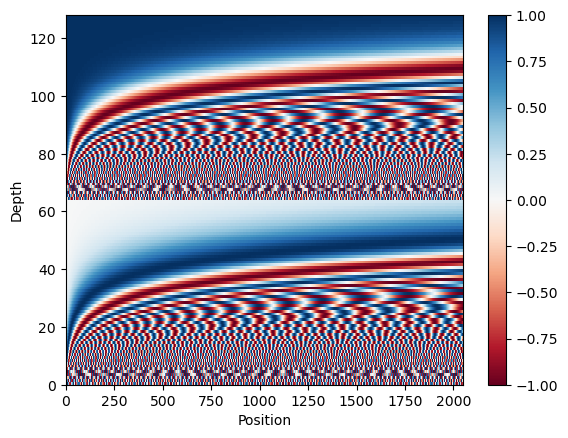

In [158]:
#@title
pos_encoding = positional_encoding(length=2048, depth=128)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [159]:
class PositionalEmbedding(tf.keras.layers.Layer):
  """
  This layer combines the input embedding with a positional encoding that helps the Transformer to understand
  the relative position of the tokens in a sequence. It takes an input sequence of tokens and converts it to
  a sequence of embedding vectors, then adds positional information to it.

  Attributes:
      vocab_size (int): The size of the vocabulary, i.e., the number of unique tokens in the input sequence.
      d_model (int): The number of dimensions in the embedding vector.

  Methods:
      compute_mask(*args, **kwargs): This method computes the mask to be applied to the embeddings.
      call(x): This method performs the computation for the layer.

  """
  def __init__(self, vocab_size, d_model):
    """
    Initializes the PositionalEmbedding layer.

    Args:
        vocab_size (int): The size of the vocabulary, i.e., the number of unique tokens in the input sequence.
        d_model (int): The number of dimensions in the embedding vector.
    """
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    """
    Computes the mask to be applied to the embeddings.

    Args:
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Returns:
        Mask to be applied to the embeddings.
    """
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    """
    Computes the output of the layer.

    Args:
        x (tf.Tensor): Input sequence of tokens.

    Returns:
        The output sequence of embedding vectors with added positional information.
    """
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [160]:
embed_pt = PositionalEmbedding(vocab_size=100, d_model=128)

pt_emb = embed_pt(sfh_inputs)

print(pt_emb.shape)

(64, 121, 128)


In [161]:
class BaseAttention(tf.keras.layers.Layer):
  """
  Base Attention layer class that contains a MultiHeadAttention, LayerNormalization and Add layer.

  Attributes:
  -----------
  kwargs: dict
      keyword arguments that will be passed to the MultiHeadAttention layer during initialization.

  Methods:
  --------
  call(inputs, mask=None, training=None):
      Performs a forward pass on the input and returns the output.

  """
  def __init__(self, **kwargs):
    """
    Initializes a new instance of the BaseAttention layer class.

    Parameters:
    -----------
    kwargs: dict
        keyword arguments that will be passed to the MultiHeadAttention layer during initialization.
    """
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [162]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    """
    Apply the global self-attention mechanism to the input sequence.

    Args:
        x: A tensor of shape `(batch_size, seq_len, embedding_dim)`
        representing the input sequence.

    Returns:
        A tensor of the same shape as the input, representing the sequence
        after being transformed by the self-attention mechanism.
    """
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [163]:
class CausalSelfAttention(BaseAttention):
  """
  Call self attention on the input sequence, ensuring that each position in the
  output depends only on previous positions (i.e. a causal model).

  Args:
      x: Input sequence tensor of shape `(batch_size, seq_len, embed_dim)`.

  Returns:
      Output sequence tensor of the same shape as the input, after self-attention
      and residual connection with layer normalization applied.
  """
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True,
    return_attention_scores=True)
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

checking

In [164]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=128)

print(pt_emb.shape)

out1 = sample_csa(embed_pt(sfh_inputs[:, :3]))
out2 = sample_csa(embed_pt(sfh_inputs))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

(64, 121, 128)


0.5391184

In [165]:
class FeedForward(tf.keras.layers.Layer):
  """
  Implements the feedforward sublayer of the transformer block.

  Parameters:
  -----------
  d_model: int
      The number of expected features in the input and output.
  dff: int
      The number of neurons in the first Dense layer.
  dropout_rate: float, optional (default=0.1)
      The dropout rate to use.

  Attributes:
  -----------
  seq: tf.keras.Sequential
      The sequential model that applies the two Dense layers and Dropout.
  add: tf.keras.layers.Add
      The addition layer that adds the residual connection.
  layer_norm: tf.keras.layers.LayerNormalization
      The normalization layer applied to the output.

  Methods:
  --------
  call(x):
      Computes the feedforward sublayer on the input tensor x and returns the output.

  """
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    """
    Passes the input tensor `x` through a feedforward network consisting of two
    dense layers with `dff` hidden units and a `relu` activation function.
    A `dropout_rate` is applied after the first dense layer to prevent overfitting.
    The output of the feedforward network is added to the original input `x` via the
    `Add()` layer. Finally, the output is normalized using the `LayerNormalization()` layer.

    Args:
        x (tf.Tensor): Input tensor with shape `(batch_size, seq_len, d_model)`.

    Returns:
        tf.Tensor: Output tensor with shape `(batch_size, seq_len, d_model)`.
    """
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


In [166]:
sample_ffn = FeedForward(128, 2048)

print(pt_emb.shape)
print(sample_ffn(pt_emb).shape)

(64, 121, 128)
(64, 121, 128)


In [167]:
class DecoderLayer(tf.keras.layers.Layer):
  """
  A single layer of the decoder in a transformer-based architecture.

  Args:
    d_model (int): The number of expected features in the input.
    num_heads (int): The number of attention heads.
    dff (int): The dimensionality of the feedforward network.
    dropout_rate (float): The dropout rate to be applied.

  Attributes:
    causal_self_attention: An instance of the `CausalSelfAttention` layer.
    cross_attention: An instance of the `CrossAttention` layer.
    ffn: An instance of the `FeedForward` layer.
    last_attn_scores: A tensor containing the last attention scores.

  """
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    """
    Forward pass of the `DecoderLayer`.

    Args:
      x (tf.Tensor): The input tensor of shape
      `(batch_size, target_seq_len, d_model)`.
      context (tf.Tensor): The context tensor of shape
      `(batch_size, input_seq_len, d_model)`.

    Returns:
      The output tensor of the `DecoderLayer` of shape
      `(batch_size, target_seq_len, d_model)`.

    """
    x = self.causal_self_attention(x=x)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.causal_self_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [168]:
class Decoder(tf.keras.layers.Layer):
  """A decoder model for sequence to sequence learning.

  This class implements a decoder layer for a transformer-based model used for sequence to sequence learning tasks. The decoder layer takes input embeddings, positional encodings, and attention masks as input, and returns the output of the decoder layer after applying a multi-head self-attention mechanism, followed by a cross-attention mechanism with the output from the encoder layers, and then applying a feed-forward neural network.

  Attributes:
    d_model (int): The number of output dimensions for each layer.
    num_layers (int): The number of layers in the decoder.
    pos_embedding (PositionalEmbedding): The positional embedding layer.
    dropout (Dropout): A dropout layer.
    dec_layers (list): A list of DecoderLayer objects.
    last_attn_scores (ndarray): The attention scores from the last decoder layer.

  Methods:
    call(x, context): Implements the forward pass for the decoder layer.
      Args:
        x (ndarray): A tensor of shape (batch_size, target_seq_len), representing the input token IDs.
        context (ndarray): A tensor of shape (batch_size, input_seq_len, d_model), representing the output from the encoder layers.
      Returns:
        ndarray: A tensor of shape (batch_size, target_seq_len, d_model), representing the output from the decoder layers.
  """
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x):
    """
    Implements the forward pass for the decoder layer.

    Args:
      x (ndarray): A tensor of shape (batch_size, target_seq_len), representing the input token IDs.
      context (ndarray): A tensor of shape (batch_size, input_seq_len, d_model), representing the output from the encoder layers.

    Returns:
      ndarray: A tensor of shape (batch_size, target_seq_len, d_model), representing the output from the decoder layers.
    """
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [169]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=1,
                         d_model=128,
                         num_heads=2,
                         dff=2048,
                         vocab_size=100)

output = sample_decoder(
    x=sfh_inputs)

# Print the shapes.
#print(en.shape)
#print(pt_emb.shape)
#print(output.shape)

In [170]:
class Transformer(tf.keras.Model):
  """
  A transformer model that consists of an encoder, a decoder and a final dense layer.

  Args:
    num_layers (int): Number of layers in both the encoder and decoder.
    d_model (int): Hidden size of the model.
    num_heads (int): Number of attention heads used in the model.
    dff (int): Size of the feedforward layer in the encoder and decoder.
    input_vocab_size (int): Size of the vocabulary of the input.
    target_vocab_size (int): Size of the vocabulary of the target.
    dropout_rate (float): Dropout rate applied to the output of each sub-layer.

  Attributes:
    encoder (Encoder): An instance of the Encoder class.
    decoder (Decoder): An instance of the Decoder class.
    final_layer (Dense): A Dense layer that converts the final transformer output to output token probabilities.

  Methods:
    call(inputs): Forward pass of the transformer model.

  Returns:
    logits (tf.Tensor): Output tensor of the final dense layer. Shape (batch_size, target_len, target_vocab_size).
  """
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    """
    Forward pass of the transformer model.

    Args:
      inputs (tuple): A tuple of two tensors. The first tensor is the context input tensor of shape (batch_size, context_len).
                      The second tensor is the target input tensor of shape (batch_size, target_len).

    Returns:
      logits (tf.Tensor): Output tensor of the final dense layer. Shape (batch_size, target_len, target_vocab_size).
    """

    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    x  = inputs

    #context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [409]:
num_layers = 10
d_model = 512
dff = 512
num_heads = 4
dropout_rate = 0.5

In [410]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=100,
    target_vocab_size=100,
    dropout_rate=dropout_rate)

In [411]:
#transformer.summary()

In [412]:
output = transformer((sfh_inputs))



In [413]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  """
  Custom learning rate schedule that implements the learning rate function
  described in the original Transformer paper. The learning rate is increased
  linearly for the first `warmup_steps` training steps, and then decreased
  proportionally to the inverse square root of the step number.

  Args:
    d_model (int): the dimensionality of the model.
    warmup_steps (int): the number of steps taken to increase the learning rate
      linearly. Default is 4000.

  Attributes:
    d_model (float): the dimensionality of the model as a float.
    warmup_steps (int): the number of steps taken to increase the learning rate
      linearly.

  Methods:
    __call__(step): returns the learning rate at the given step.

  Returns:
    The learning rate at the given step.
  """
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    """
    Returns the learning rate at the given step.

    Args:
      step (int): the current training step.

    Returns:
      The learning rate at the given step as a float32 tensor.
    """
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [414]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [415]:
def masked_loss(label, pred):
  """
  Calculates the masked sparse categorical cross-entropy loss between the true labels and predicted labels.

  Args:
      label: A tensor of shape (batch_size, seq_length) containing the true labels.
      pred: A tensor of shape (batch_size, seq_length, target_vocab_size) containing the predicted labels.

  Returns:
      A scalar tensor representing the masked loss value.

  """
  mask = label < 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  #loss *= mask

  loss = tf.reduce_sum(loss)#/tf.reduce_sum(mask)
  return loss

In [416]:
def masked_accuracy(label, pred):
  """
  Calculates the masked accuracy between the true labels and predicted labels.

  Args:
      label: A tensor of shape (batch_size, seq_length) containing the true labels.
      pred: A tensor of shape (batch_size, seq_length, target_vocab_size) containing the predicted labels.

  Returns:
      A scalar tensor representing the masked accuracy value.

  """
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label < 0

  #match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)#/tf.reduce_sum(mask)

In [417]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [418]:
transformer.summary()

Model: "transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_8 (Decoder)         multiple                  47334400  
                                                                 
 dense_73 (Dense)            multiple                  51300     
                                                                 
Total params: 47,385,700
Trainable params: 47,385,700
Non-trainable params: 0
_________________________________________________________________


In [419]:
transformer.decoder(sfh_inputs)
print(sfh_inputs.shape)

(64, 121)


In [420]:
print(train_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 121), dtype=tf.int32, name=None), TensorSpec(shape=(None, 121), dtype=tf.int32, name=None))>


In [421]:
transformer.fit(train_batches,
                epochs=10)

Epoch 1/10
79/79 [==============================] - 55s 278ms/step - loss: 17958.0586 - masked_accuracy: 4562.0635
Epoch 2/10
79/79 [==============================] - 23s 280ms/step - loss: 8253.3105 - masked_accuracy: 5943.7217
Epoch 3/10
79/79 [==============================] - 23s 279ms/step - loss: 6532.0864 - masked_accuracy: 6067.1392
Epoch 4/10
79/79 [==============================] - 23s 280ms/step - loss: 4942.9800 - masked_accuracy: 6223.3545
Epoch 5/10
79/79 [==============================] - 23s 280ms/step - loss: 4094.2087 - masked_accuracy: 6278.6963
Epoch 6/10
79/79 [==============================] - 23s 280ms/step - loss: 3671.0381 - masked_accuracy: 6341.3291
Epoch 7/10
79/79 [==============================] - 23s 280ms/step - loss: 3455.4109 - masked_accuracy: 6375.8101
Epoch 8/10
79/79 [==============================] - 23s 280ms/step - loss: 3279.1465 - masked_accuracy: 6420.8354
Epoch 9/10
79/79 [==============================] - 23s 281ms/step - loss: 3207.4578 - 

In [422]:
class Translator(tf.Module):
    """A translator that uses a transformer model to translate 
    sentences from Portuguese to English.

    Attributes:
      tokenizers (dict): A dictionary of tokenizers for the 
      Portuguese and English languages.
      transformer (tf.keras.Model): A transformer model that can 
      be used for sequence-to-sequence translation.
    """
    def __init__(self, transformer, seq_init):
        self.transformer = transformer
        self.seq_init = seq_init
        

    def __call__(self, max_length=MAX_TOKENS):
        """Translates a sentence from Portuguese to English.

        Args:
            sentence (str): The sentence to be translated.
            max_length (int): The maximum number of tokens in the output sentence.

        Returns:
            tuple: A tuple containing the translated text, the tokens of the translated text,
                and the attention weights of the transformer model.
        """


        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        print(self.seq_init.shape)
        for k in range(tf.shape(self.seq_init)[0]): 
            #output_array = output_array.write(k, tf.cast(self.seq_init[k], dtype=tf.int64))
            output_array = output_array.write(k, tf.constant(tf.cast(self.seq_init[k],dtype=tf.int64), shape=(1,), dtype=tf.int64))


        

        for i in tf.range(tf.shape(self.seq_init)[0],121):
            
            output = tf.transpose(output_array.stack())
            #output = tf.expand_dims(output, -1)
            #print(output.shape)

            predictions = self.transformer(output, training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)
            
            #predicted_id = tf.squeeze(predicted_id)  # Squeeze unnecessary dimensions

            
            #print(f"pred id = {predicted_id}")

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            #output_array = output_array.write(i+1, predicted_id[0])
 
            output_array = output_array.write(i, predicted_id[0])
        


            output = tf.transpose(output_array.stack())
            
            #print(f"output : {output}")
            
            
            if predicted_id == 99:
                break

        self.transformer( output[:,:-1], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores
        
        print(output)

        return output, attention_weights 

In [428]:
for sfh_inputs1, sfh_labels1 in train_batches.take(100):
  break

seq_init = sfh_inputs1[37][0:30]
print(seq_init)

tf.Tensor(
[ 0  0  1  1  2  3  4  5  7  9 11 15 19 22 26 31 35 39 43 47 50 55 57 61
 64 67 69 72 73 75], shape=(30,), dtype=int32)


In [429]:

translator = Translator(transformer, seq_init)

In [430]:
output = translator()

(30,)
tf.Tensor(
[[ 0  0  1  1  2  3  4  5  7  9 11 15 19 22 26 31 35 39 43 47 50 55 57 61
  64 67 69 72 73 75 78 80 82 83 84 86 87 88 89 90 91 92 93 94 95 96 97 98
  99]], shape=(1, 49), dtype=int64)


In [431]:
sequence = output[0].numpy()

(1, 49)
[[ 0  0  1  1  2  3  4  5  7  9 11 15 19 22 26 31 35 39 43 47 50 55 57 61
  64 67 69 72 73 75 78 80 82 83 84 86 87 88 89 90 91 92 93 94 95 96 97 98
  99]]


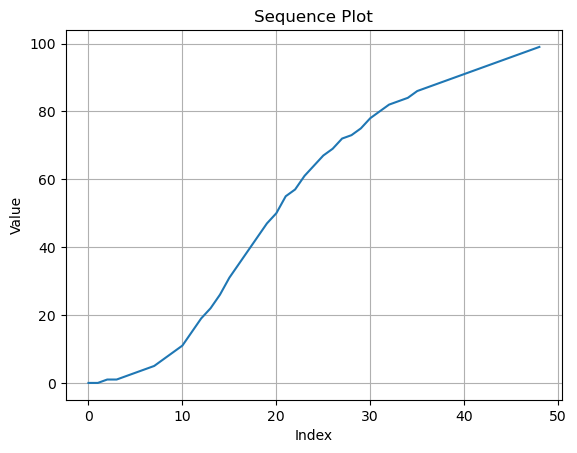

In [432]:
print(sequence.shape)
print(sequence)
plt.plot(np.squeeze(sequence))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sequence Plot')
plt.grid()
plt.show()
